In [49]:
import pandas as pd
import numpy as np
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
excel_file = 'German Credit Data.xlsx'
df = pd.read_excel(excel_file)

# Map attribute values
attribute_mapping = {
    'A11': '< 0 DM',
    'A12': '0 <= ... < 200 DM',
    'A13': '... >= 200 DM / salary assignments for at least 1 year',
    'A14': 'no checking account',
    'A30': 'no credits taken/ all credits paid back duly',
    'A31': 'all credits at this bank paid back duly',
    'A32': 'existing credits paid back duly till now',
    'A33': 'delay in paying off in the past',
    'A34': 'critical account/ other credits existing (not at this bank)',
    'A40': 'car (new)',
    'A41': 'car (used)',
    'A42': 'furniture/equipment',
    'A43': 'radio/television',
    'A44': 'domestic appliances',
    'A45': 'repairs',
    'A46': 'education',
    'A48': 'retraining',
    'A49': 'business',
    'A410': 'others',
    'A61': '< 100 DM',
    'A62': '100 <= ... < 500 DM',
    'A63': '500 <= ... < 1000 DM',
    'A64': '... >= 1000 DM',
    'A65': 'unknown/ no savings account',
    'A71': 'unemployed',
    'A72': '< 1 year',
    'A73': '1 <= ... < 4 years',
    'A74': '4 <= ... < 7 years',
    'A75': '... >= 7 years',
    'A91': 'male : divorced/separated',
    'A92': 'female : divorced/separated/married',
    'A93': 'male : single',
    'A94': 'male : married/widowed',
    'A95': 'female : single',
    'A101': 'none',
    'A102': 'co-applicant',
    'A103': 'guarantor',
    'A121': 'real estate',
    'A122': 'building society savings agreement/ life insurance',
    'A123': 'car or other, not in attribute 6',
    'A124': 'unknown / no property',
    'A141': 'bank',
    'A142': 'stores',
    'A143': 'none',
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free',
    'A171': 'unemployed/ unskilled - non-resident',
    'A172': 'unskilled - resident',
    'A173': 'skilled employee / official',
    'A174': 'management/ self-employed/ highly qualified employee/ officer',
    'A191': 'none',
    'A192': 'yes, registered under the customers name',
    'A201': 'yes',
    'A202': 'no'
}
# Replace values in the dataframe
df.replace(attribute_mapping, inplace=True)

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("German Credit Data Analysis Dashboard", className="text-center mt-3"),

    # Outliers in Age and Credit amount
    html.Div([
        html.H2("Outliers Detection", className="mt-3"),
        html.Div([
            dcc.Graph(id='age-outliers-histogram')
        ], className="col-md-6"),
        html.Div([
            dcc.Graph(id='credit-outliers-histogram')
        ], className="col-md-6")
    ], className="row"),

    # Scatter plots for numerical variables vs Outcome
    html.Div([
        html.H2("Scatter Plot: Numerical vs Outcome", className="mt-3"),
        html.Div([
            dcc.Dropdown(
                id='x-variable',
                options=[{'label': col, 'value': col} for col in df.columns],
                value='Age'
            )
        ], className="col-md-4"),
        html.Div([
            dcc.Dropdown(
                id='y-variable',
                options=[{'label': col, 'value': col} for col in df.columns],
                value='Credit amount'
            )
        ], className="col-md-4"),
        html.Div([
            dcc.Dropdown(
                id='outcome-variable',
                options=[{'label': 'Outcome', 'value': 'Outcome'}],
                value='Outcome'
            )
        ], className="col-md-4"),
        html.Div([
            dcc.Graph(id='scatter-plot')
        ], className="col-md-12")
    ], className="row"),

    # Data table
    html.Div([
        html.H2("Top 10 Records", className="mt-3"),
        html.Div(id='data-table-container')
    ], className="row")
])

# Callbacks to update histograms for outliers in Age and Credit amount
@app.callback(
    Output('age-outliers-histogram', 'figure'),
    Output('credit-outliers-histogram', 'figure'),
    [Input('x-variable', 'value'),
     Input('y-variable', 'value')]
)
def update_outliers_histogram(x_variable, y_variable):
    # Check for outliers in Age and Credit amount
    outliers_age = df[np.abs(df[x_variable] - df[x_variable].mean()) > (3 * df[x_variable].std())]
    outliers_credit_amount = df[np.abs(df[y_variable] - df[y_variable].mean()) > (3 * df[y_variable].std())]

    # Visualize the outliers using histogram
    fig_age = px.histogram(outliers_age, x=x_variable, title=f'Outliers in {x_variable}')
    fig_credit_amount = px.histogram(outliers_credit_amount, x=y_variable, title=f'Outliers in {y_variable}')

    return fig_age, fig_credit_amount


# Callback to update scatter plot based on selected variables
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('x-variable', 'value'),
     Input('y-variable', 'value'),
     Input('outcome-variable', 'value')]
)
def update_scatter_plot(x_variable, y_variable, outcome_variable):
    fig = px.scatter(df, x=x_variable, y=y_variable, color=outcome_variable,
                     title=f'{x_variable} vs {y_variable} colored by {outcome_variable}')
    return fig


# Callback to update data table
@app.callback(
    Output('data-table-container', 'children'),
    [Input('scatter-plot', 'selectedData')]
)
def update_data_table(selected_data):
    if selected_data:
        indices = [point['pointIndex'] for point in selected_data['points']]
        selected_records = df.iloc[indices].to_html()
        return html.Table([html.Tr([html.Th(col) for col in df.columns])] +
                          [html.Tr([html.Td(df.iloc[i][col]) for col in df.columns]) for i in indices])
    else:
        return html.P("No data selected.")


if __name__ == '__main__':
    app.run_server(debug=True)

<Figure size 1000x600 with 0 Axes>

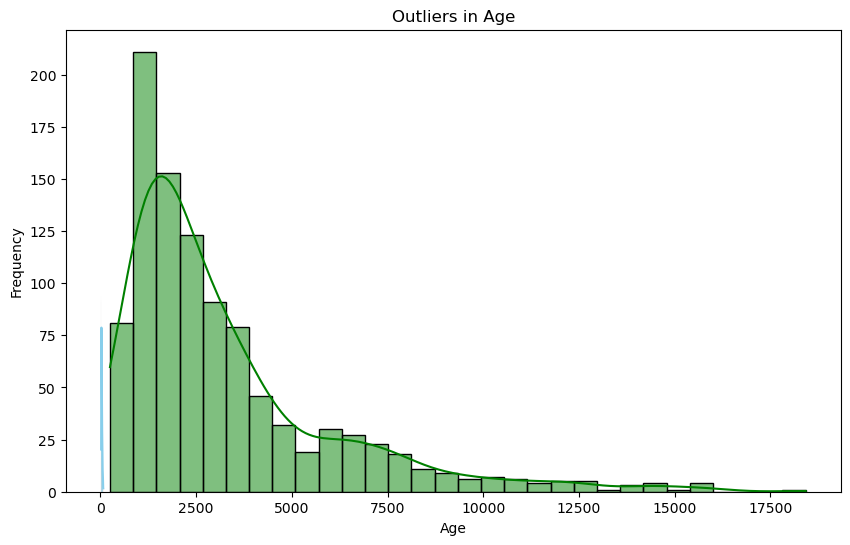

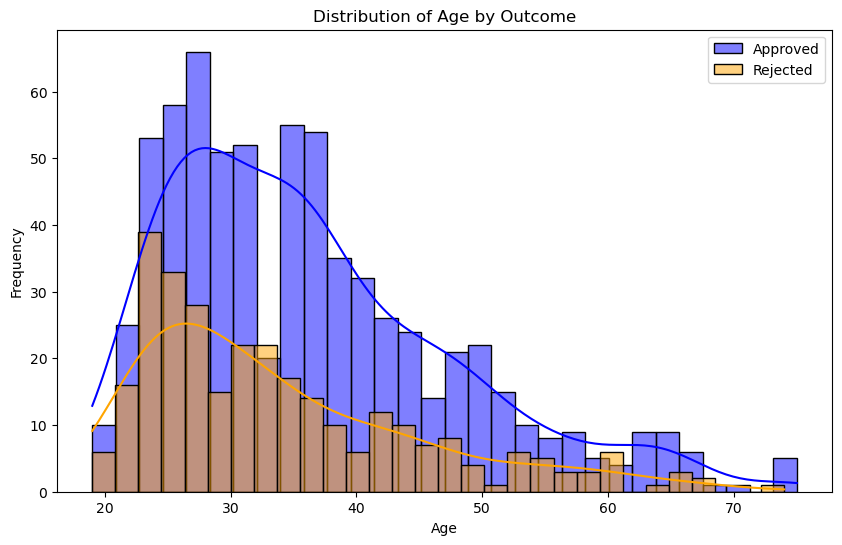

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data by outcome
approved_age = df[df['Outcome'] == 1]['Age']
rejected_age = df[df['Outcome'] == 2]['Age']

# Plot histograms for each outcome
plt.figure(figsize=(10, 6))
sns.histplot(data=approved_age, bins=30, kde=True, color='blue', label='Approved', alpha=0.5)
sns.histplot(data=rejected_age, bins=30, kde=True, color='orange', label='Rejected', alpha=0.5)
plt.title('Distribution of Age by Outcome')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


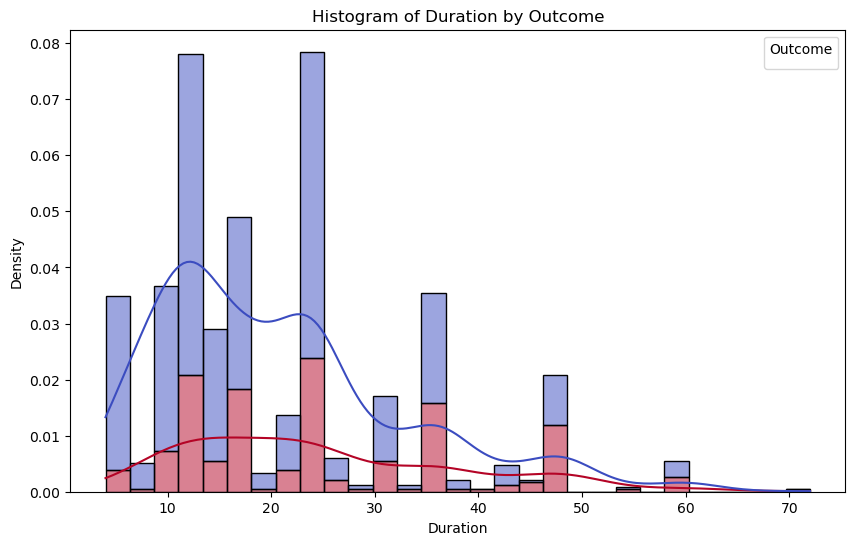

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


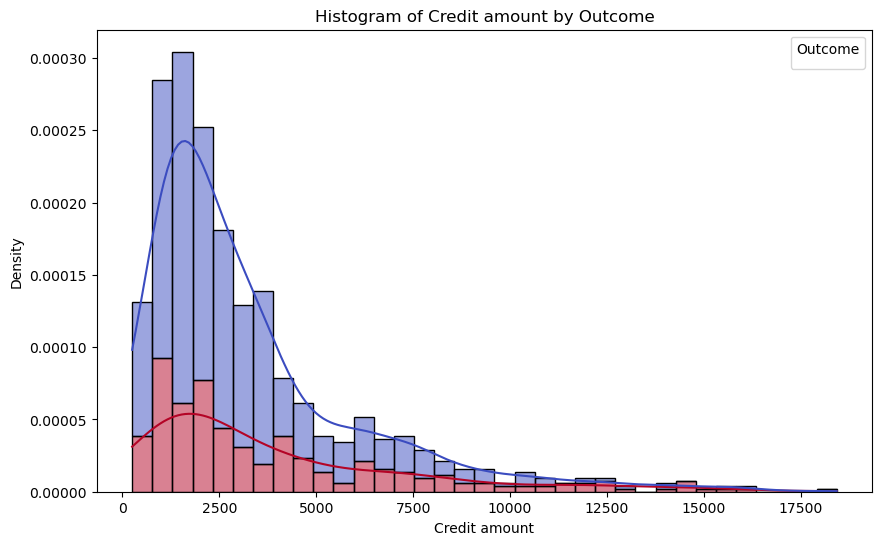

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


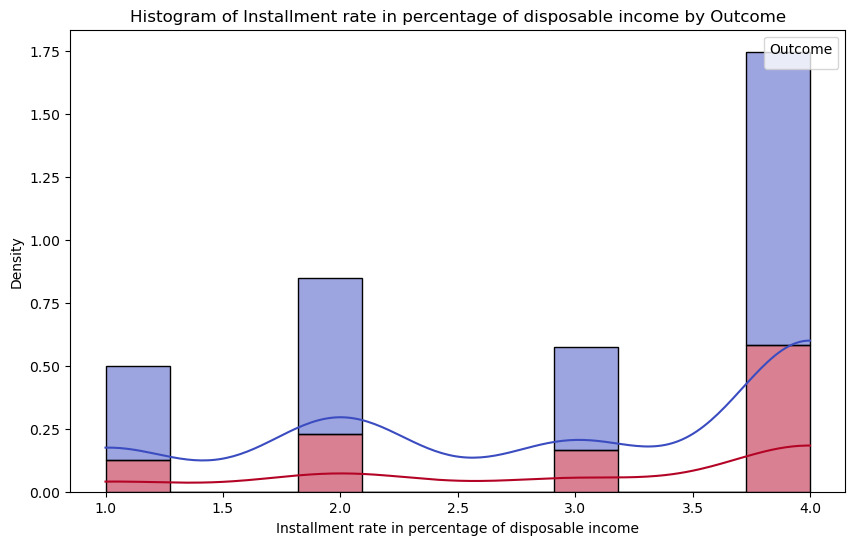

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


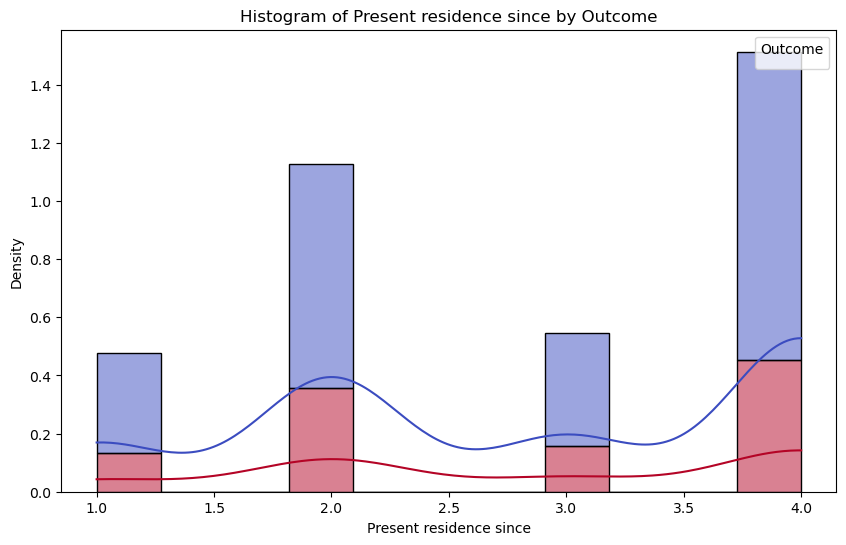

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


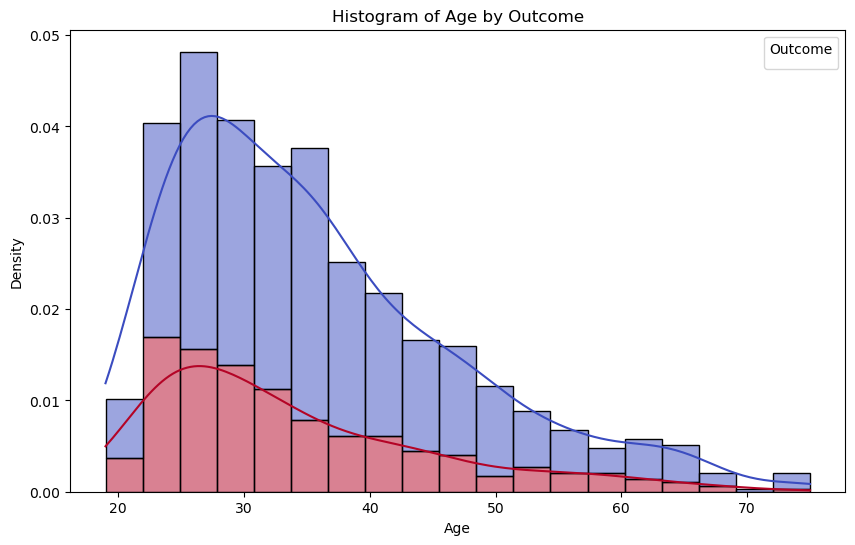

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


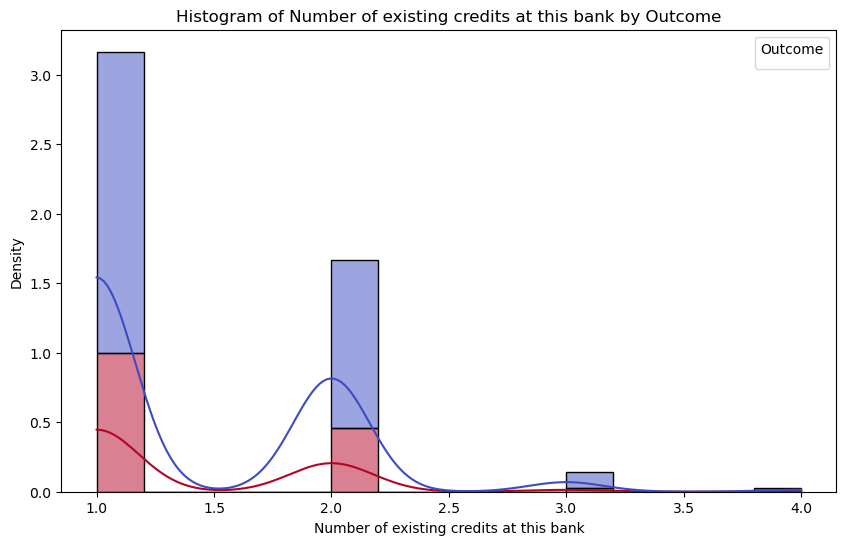

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


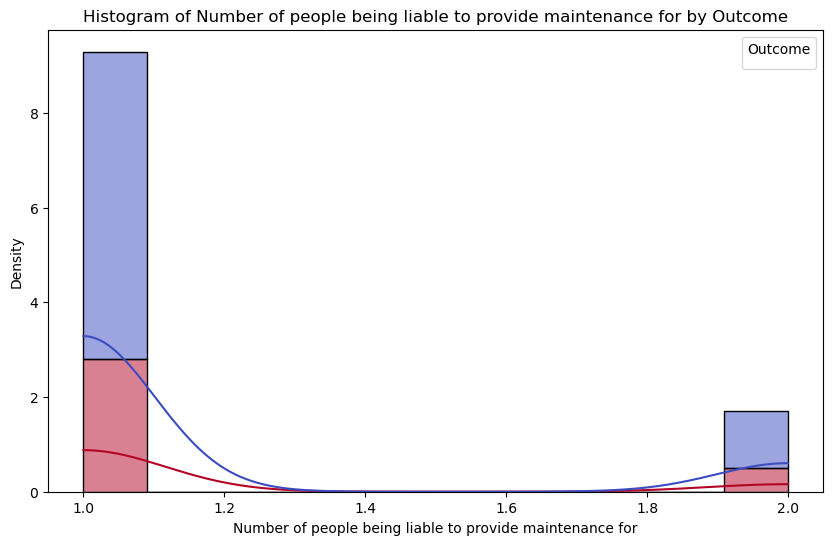

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for plotting
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for each numerical variable against the outcome
for col in numerical_columns:
    if col != 'Outcome':  # Exclude 'Outcome' variable
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x=col, hue='Outcome', multiple='stack', palette='coolwarm', kde=True, stat='density')
        plt.title(f'Histogram of {col} by Outcome')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend(title='Outcome', loc='upper right')
        plt.show()

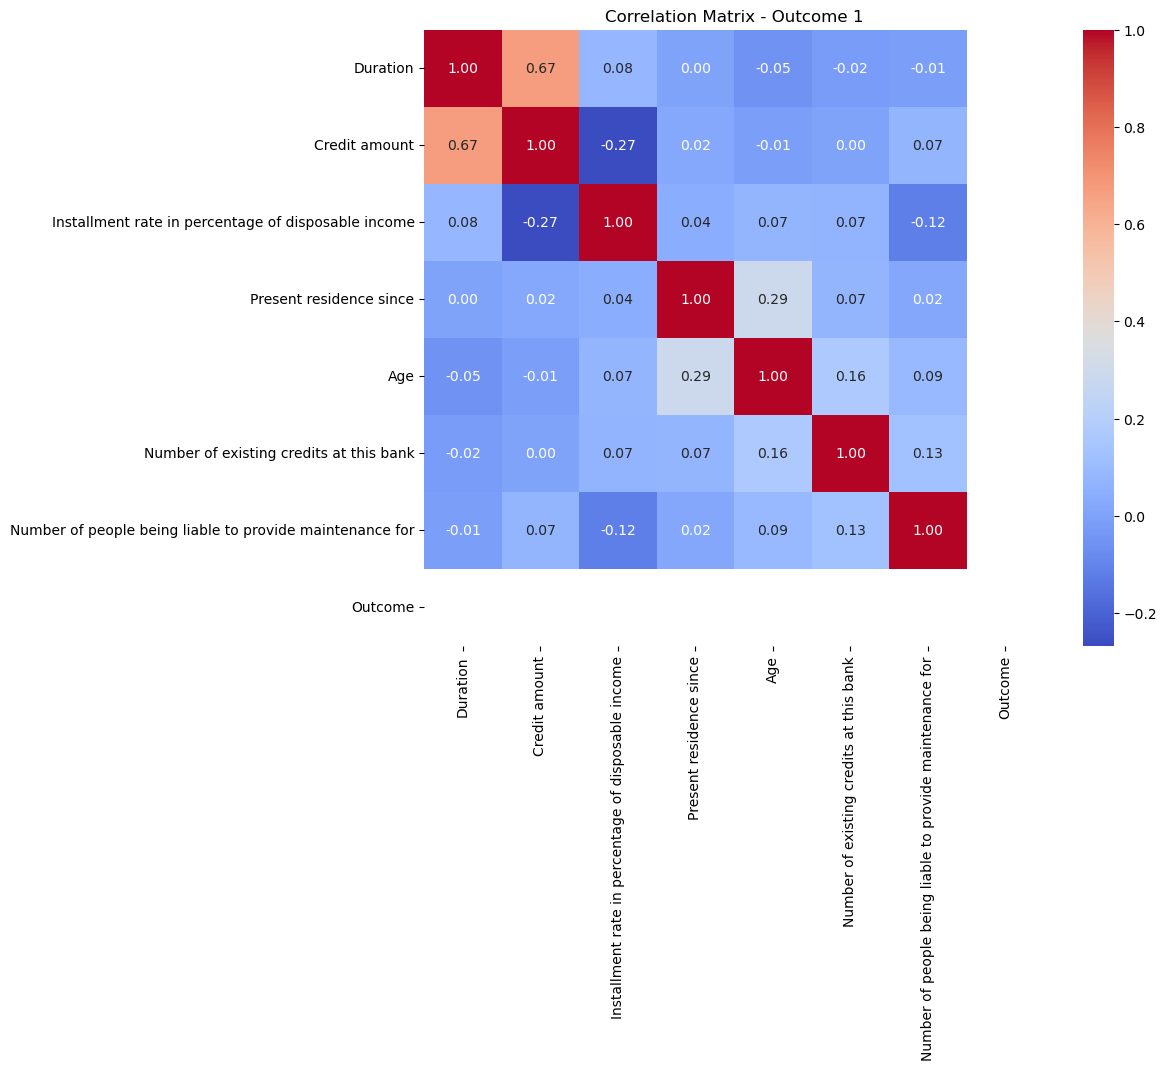

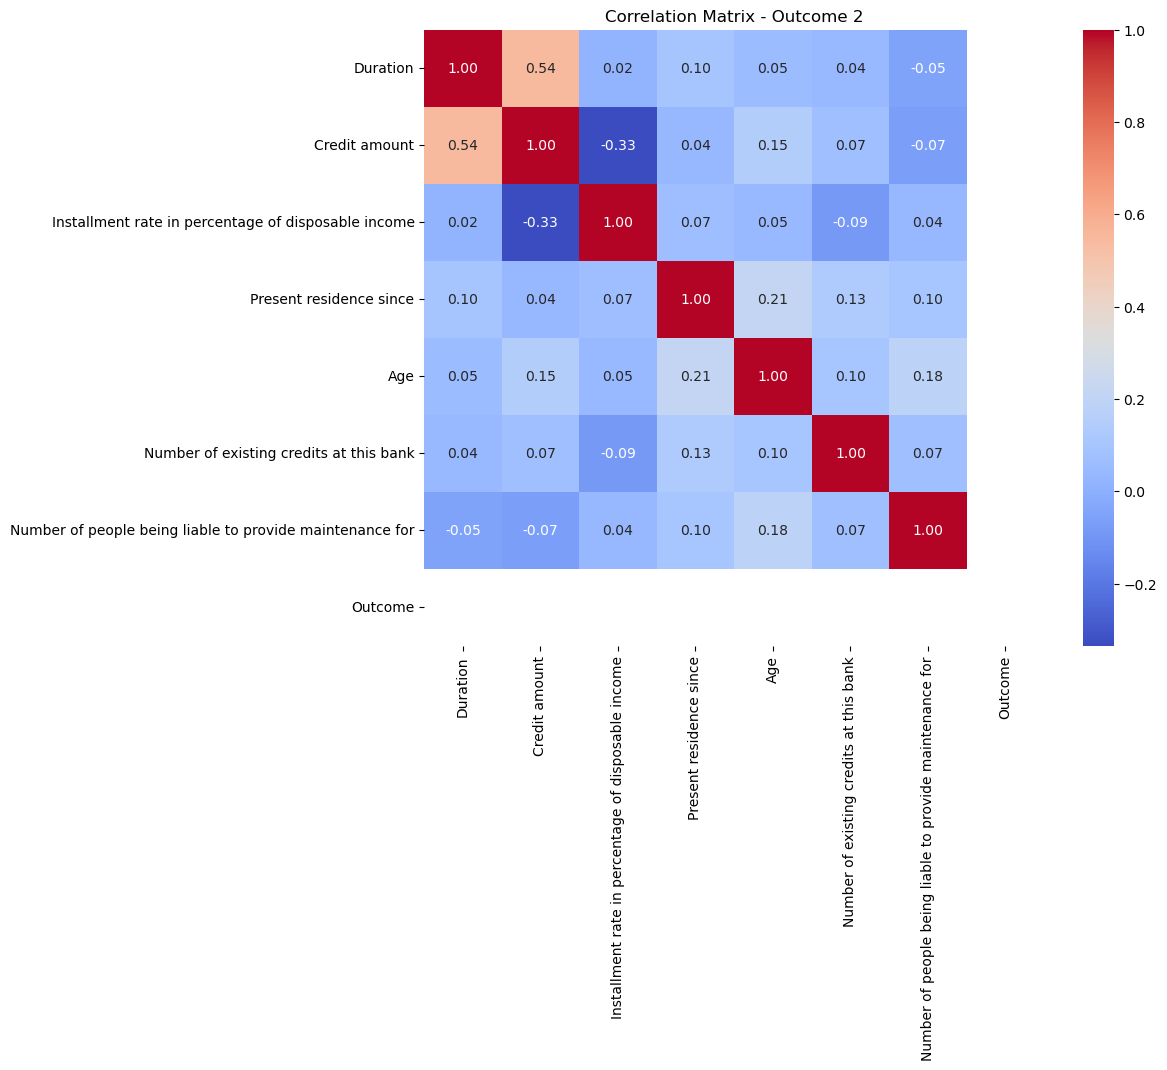

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter DataFrame for each outcome
outcome_1_df = df[df['Outcome'] == 1]
outcome_2_df = df[df['Outcome'] == 2]

# Compute correlation matrices for each outcome
corr_matrix_outcome_1 = outcome_1_df.corr(numeric_only=True)
corr_matrix_outcome_2 = outcome_2_df.corr(numeric_only=True)

# Plot correlation matrix for Outcome 1
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_outcome_1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - Outcome 1')
plt.show()

# Plot correlation matrix for Outcome 2
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_outcome_2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - Outcome 2')
plt.show()